In [ ]:
# default_exp preprocessing

# Preprocessing

> Make png mask for DL models.

In [ ]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# hide
from nbdev.showdoc import *

In [ ]:
# export
from steel_segmentation.core import *
from steel_segmentation.data import *
from fastcore.foundation import *
from fastai.vision.all import *
from PIL import Image
from collections import defaultdict
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np

To build a segmentation DataLoader we need:

1. [Masks from RLE](#Masks-from-RLE): functions to convert RLE encoded pixels to masks

2. [Codes](#Codes): the type of pixels in the images

3. [Labels](#Labels): the masks for each image

In [ ]:
# hide
only_imgs = ["0a1cade03.jpg", "bca4ae758.jpg", "988cf521f.jpg", "b6a257b28.jpg",
             "b2ad335bf.jpg", "72aaba8ad.jpg", "f383950e8.jpg"]
train = train[train["ImageId"].isin(only_imgs)].copy()
train_all = train_all[train_all["ImageId"].isin(only_imgs)].copy()
train_multi = train_multi[train_multi["ImageId"].isin(only_imgs)].copy()

## Masks from RLE

As for the `data` module, I first select an image to test the functions.

            ImageId  ClassId
6757  f383950e8.jpg        3
6758  f383950e8.jpg        4


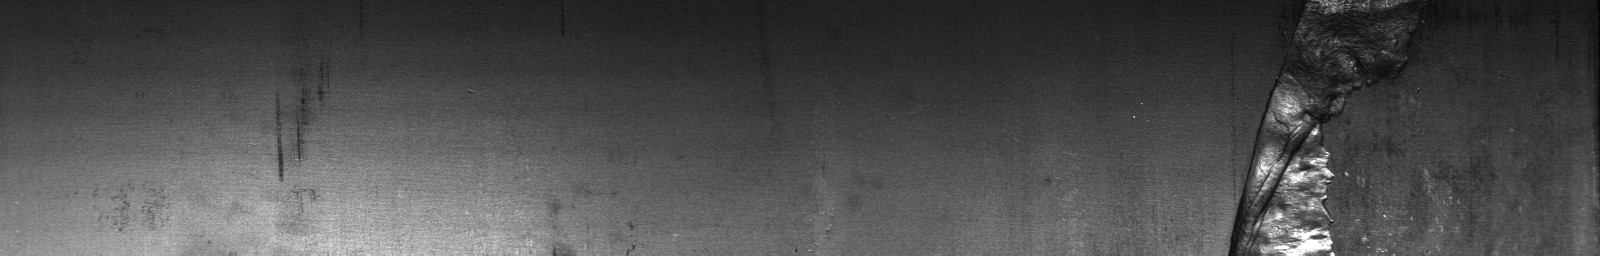

In [ ]:
img_id = "f383950e8.jpg"
tmp_df = train[train['ImageId'] == img_id]
img_path = train_path / img_id
im = Image.open(img_path)


print(tmp_df[["ImageId", "ClassId"]])
height, width = im.shape
im

In [ ]:
# export
def rle_to_mask(rle: str, class_id: int, height: int, width: int) -> np.ndarray:
    """
    Convert RLE encoded pixels to numpy array for only one class_id
    """
    rows, cols = height, width
    mask = np.zeros(rows*cols, dtype=np.uint8)

    if rle == -1:
        return mask.reshape(cols, rows).T

    encoded_pixels = [int(i) for i in rle.split(" ")]

    # (n, 2) as [[pos, offs], ... ]
    rle_pairs = np.array(encoded_pixels).reshape(-1, 2)

    for index, length in rle_pairs:
        index -= 1
        mask[index: (index + length)] = class_id

    mask = mask.reshape(cols, rows)
    return mask.T

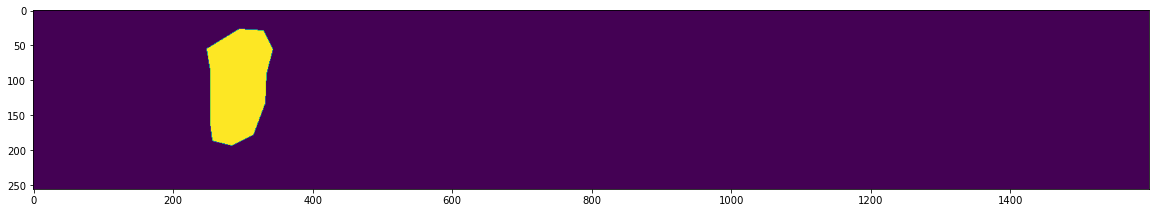

In [ ]:
im = rle_to_mask(tmp_df["EncodedPixels"].iloc[0],
                 tmp_df["ClassId"].iloc[0], height, width)

plt.figure(figsize=(20, 5))
plt.imshow(im)
plt.show()

In [ ]:
# export
def multi_rle_to_mask(img_path: str, df: pd.DataFrame = train_all) -> np.ndarray:
    """
    Convert all RLE encoded pixels for an image and returns the mask
    """
    height, width = 256, 1600

    def build_mask(df) -> np.ndarray:
        masks = defaultdict(np.ndarray)
        for num, row in enumerate(df.itertuples()):
            masks[num] = rle_to_mask(
                row.EncodedPixels, row.ClassId, height, width)

        mask = masks.pop(0)

        items_left = len(masks)
        if items_left:
            for item in range(items_left):
                mask_to_add = masks.get(item + 1)
                mask = np.add(mask, mask_to_add)

        return mask

    img_id = img_path.name
    img_df = df.loc[df["ImageId"] == img_id]
    return build_mask(img_df)

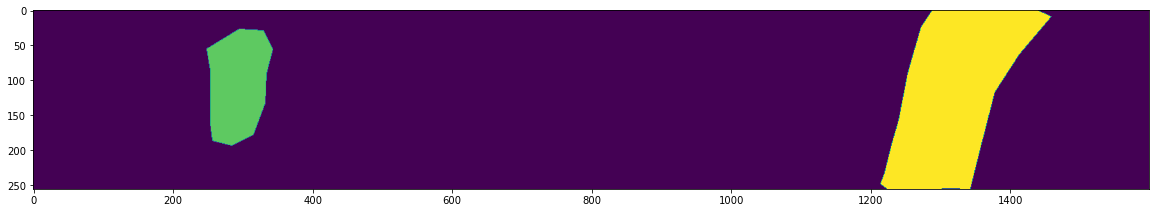

In [ ]:
im = multi_rle_to_mask(img_path)

plt.figure(figsize=(20, 5))
plt.imshow(im)
plt.show()

In [ ]:
# export
def img_with_mask(img_path: str):
    return np.array(Image.open(img_path)), multi_rle_to_mask(img_path)

In [ ]:
img, mask = img_with_mask(img_path)
img.shape, mask.shape, type(img), type(mask)

((256, 1600, 3), (256, 1600), numpy.ndarray, numpy.ndarray)

## Codes

Codes are the labels for the corrisponding pixel values in the mask images.

In [ ]:
codes_file_name = "codes.txt"
codes_path = Path(path/codes_file_name)

if not codes_path.is_file():
    classes = np.unique(train.ClassId.values)
    classes = np.insert(classes, 0, 0)
    np.savetxt(path/'codes.txt', classes, fmt='%u')
else:
    classes = np.loadtxt(codes_path, dtype=np.uint8)

In [ ]:
assert classes.tolist() == [0, 1, 2, 3, 4]

In [ ]:
assert codes_path.is_file()

## Labels

To train a segmentation model we need pixel labels for every training image. 

As a first approach, I tried to create masks only for the images that present a defect. But this will exclude all the good images that can be used to teach to the model to recognize good steel pixels.
Then I created the masks for all the images in the training folder.

NB: masks must be PNG files and not JPEG because JPEG's compression makes the labels get messed up occasionally ([source](https://forums.fast.ai/t/unet-learner-failing-with-a-cuda-device-assert/66747/4)).

In [ ]:
# export
labels_dir = path / "labels"


def create_masks(df: pd.DataFrame):
    """Create the masks for ImageId in df"""
    paths = []
    for img_id in df["ImageId"].tolist():
        img_path = train_path / img_id
        img_label = labels_dir/f"{img_path.stem}_P.png"
        if not img_label.is_file():
            mask = multi_rle_to_mask(img_path)
            im = Image.fromarray(mask)
            im.save(img_label)
        paths.append(img_label)
    return L(paths)

In [ ]:
masks = create_masks(train_multi)

With the PNG extension, the multi-label segmentation problem would seem desappear.

In [ ]:
ntraining = get_image_files(train_path)
assert len(ntraining) == len(masks)

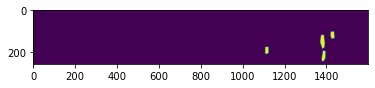

In [ ]:
# missing
idx = get_random_idx(len(masks))
im = np.array(Image.open(masks[idx[0]]))
plt.imshow(im)

In [ ]:
class_ids = np.unique(im).tolist()
check = [c in classes for c in class_ids]
assert False not in check

In [ ]:
# hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_core.ipynb.
Converted 01_data.ipynb.
Converted 02_preprocessing.ipynb.
Converted 03_model.fastai.ipynb.
Converted 04_model.metrics.ipynb.
Converted index.ipynb.
